# Taxaprofiler evaluation by simulaiton data


# Step 1: Barcode generation 

### Design

1. 100 different organism

100 random species from NCBI

2. generate single cell fasta files 

each barcode has 1000-10000 reads

each specie has 100 barcodes

each barcode has <=49% contamination random chosen from combined fasta

3. clustering of barcodes according to Kraken, Metaphlan, and Kaiju

4. metagenome assembly VS guided assembly


## collection of the organisms


100 uncommon organism randomely chose from refseq

wget https://ftp.ncbi.nlm.nih.gov/genomes/refseq/bacteria/assembly_summary.txt

wc -l assembly_summary.txt 
218873 assembly_summary.txt

In [322]:
# seed the pseudorandom number generator
from random import seed
from random import random, choice, randint
import os
import pandas as pd
import math
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# prepare a sequence
seq = [i for i in range(218873)]
selects = []
n = 0
while n < 100:
    select = choice(seq) # select one from the total 218873 available assemly
    if select not in selects:
        s = str(select)+'p' 
        selects.append(s)
        n +=1

In [14]:
selects=['161781p','123157p','3852p','130029p','81338p','143933p','4220p','117728p','134041p','190728p','79345p','201655p','124655p','121117p','112378p','12633p','204275p','63938p','26288p','56713p','6236p','138004p','114647p','119581p','194322p','51987p','155885p','162271p','203685p','26058p','33503p','162504p','141914p','84200p','30098p','73278p','115699p','121365p','89241p','31263p','135258p','127996p','120686p','166966p','49357p','191802p','132538p','109579p','58036p','76659p','42997p','45120p','38316p','161884p','175581p','66240p','201441p','8405p','120815p','113498p','57467p','65866p','36232p','72253p','14884p','202935p','59056p','185500p','101387p','92645p','92689p','107345p','200527p','165520p','25252p','169528p','187686p','215833p','110495p','112169p','196164p','119707p','136913p','137605p','63946p','215694p','94672p','152277p','59150p','135238p','196570p','1968p','80181p','129373p','2519p','204049p','172608p','28217p','17496p','18442p']

In [17]:
input_dir = '/drive4/xiangpeng/Project/bacteria/simulation_3/original_fa/'
asb_summary = input_dir + 'assembly_summary.txt'

In [34]:
# extract the information for the selected
slcted_summary = input_dir + 'selected_file_info.txt' # this file contains all the information of the 100 selected assembly
sed_cmd = "sed -n {} {} > {}".format(';'.join(selects),asb_summary, slcted_summary)
#print(sed_cmd)
#os.system(sed_cmd) 

In [35]:
# extract the ftp address for the selected and download the fasta files
ftp_file = input_dir + 'ftp.info'
cat_cmd = "cat {} |awk '{}' | \sed -r {}|(ftp://ftp.ncbi.nlm.nih.gov/genomes/all/.+/)(GCF_.+)|{}_genomic.fna.gz|{} > {}".format(slcted_summary, '{FS="\t"}  !/^#/ {print $20}', " 's","\1\2/\2", "''", ftp_file)
print(cat_cmd)
#os.system(cat_cmd) # this file contains all the 

cat /drive4/xiangpeng/Project/bacteria/simulation_3/original_fa/selected_file_info.txt |awk '{FS="	"}  !/^#/ {print $20}' | \sed -r  's|(ftp://ftp.ncbi.nlm.nih.gov/genomes/all/.+/)(GCF_.+)|/_genomic.fna.gz|'' > /drive4/xiangpeng/Project/bacteria/simulation_3/original_fa/ftp.info


In [36]:
#download all the fasta files with the ftp links
wget_cmd = 'wget --input {}'.format(ftp_file)
print(wget_cmd)
#os.system(wget_cmd)

wget --input /drive4/xiangpeng/Project/bacteria/simulation_3/original_fa/ftp.info


In [57]:
# make a list of the fasta files
ls_of_fa = input_dir + 'all_fna.lst'
ls_cmd =  'ls {}*.fna > {}'.format(input_dir, ls_of_fa)
print(ls_cmd)
#os.system(ls_cmd)

ls /drive4/xiangpeng/Project/bacteria/simulation_3/original_fa/*.fna > /drive4/xiangpeng/Project/bacteria/simulation_3/original_fa/all_fna.lst


In [40]:
# combine all the fasta files
combined_fa =  input_dir + 'combined.fna'
fa_cmd = "any2fasta {}*.fna > {}".format(input_dir, combined_fa)
print(fa_cmd)
#os.system(fa_cmd)

any2fasta /drive4/xiangpeng/Project/bacteria/simulation_3/original_fa/*.fna > /drive4/xiangpeng/Project/bacteria/simulation_3/original_fa/combined.fna


In [37]:
# Extract the strain info 
strain_info = input_dir + 'strain.info'
strain_cmd =  "cat {}| awk ' {} !/^#/ {}' >  {} ".format(slcted_summary,'{FS="\t"}', "{print $1, $8, $9}", strain_info)
print(strain_cmd)
#os.system(strain_cmd)

cat /drive4/xiangpeng/Project/bacteria/simulation_3/original_fa/selected_file_info.txt| awk ' {FS="	"} !/^#/ {print $1, $8, $9}' >  /drive4/xiangpeng/Project/bacteria/simulation_3/original_fa/strain.info 


In [38]:
os.system('head {} -n 5'.format(strain_info))

GCF_001507125.1 jejuni strain=CJ677CC024
GCF_006345975.1 Campylobacter jejuni strain=Shff_H-m_2000
GCF_003639845.1 Helicobacter pylori strain=B362
GCF_009740755.1 Helicobacter pylori strain=MHP30
GCF_001037345.1 Pseudomonas aeruginosa strain=Pae_CF67.07o


0

In [41]:
strain_info= input_dir + 'strain.info'
fna_lst =  input_dir +'all_fna.lst'
fna_files =  pd.read_csv(fna_lst, names =['files'])['files'].tolist()

In [69]:
info = open(strain_info,'r')

refseq_taxa = pd.DataFrame(columns = ['refSeqID','genera', 'specie', 'strain','fna_file'])

while(True):
    line = info.readline()
    if not line:
        break
    refSeqNum = line.split(' ', 1)[0]
    strain = line.split(' ', 1)[1].split('\n')[0]
    specie = ' '.join(strain.split(' ')[0:2]).split('strain=')[0]
    genera = strain.split(' ')[0]
    fna_file = [fna for fna in fna_files if fna.startswith(refSeqNum)][0]
    refseq_taxa.loc[len(refseq_taxa)]= [refSeqNum, genera, specie, strain, fna_file]
    

In [72]:
refseq_taxa.head()

,refSeqID,genera,specie,strain,fna_file
0,GCF_001507125.1,jejuni,jejuni,jejuni strain=CJ677CC024,GCF_001507125.1_ASM150712v1_genomic.fna
1,GCF_006345975.1,Campylobacter,Campylobacter jejuni,Campylobacter jejuni strain=Shff_H-m_2000,GCF_006345975.1_ASM634597v1_genomic.fna
2,GCF_003639845.1,Helicobacter,Helicobacter pylori,Helicobacter pylori strain=B362,GCF_003639845.1_ASM363984v1_genomic.fna
3,GCF_009740755.1,Helicobacter,Helicobacter pylori,Helicobacter pylori strain=MHP30,GCF_009740755.1_ASM974075v1_genomic.fna
4,GCF_001037345.1,Pseudomonas,Pseudomonas aeruginosa,Pseudomonas aeruginosa strain=Pae_CF67.07o,GCF_001037345.1_ASM103734v1_genomic.fna


## Barcode generation

#### generage barcode answer keys

In [83]:
fna_dir = '/drive4/xiangpeng/Project/bacteria/simulation_3/original_fa/'
output_dir = '/drive4/xiangpeng/Project/bacteria/simulation_3/sc_fa/'
combined_fa = '/drive4/xiangpeng/Project/bacteria/simulation_3/combined_fa/all.fna'
fna_files = pd.read_csv(fna_dir+'all_fna.lst', names = ['files'])['files'].tolist()

['GCF_000216975.1_CLC_glsol122_genomic.fna',
 'GCF_000265845.1_CIO151_genomic.fna',
 'GCF_000289835.1_ASM28983v1_genomic.fna',
 'GCF_000631145.1_Stre_pyog_ABC020057168_V1_genomic.fna',
 'GCF_000638675.1_Stap_aure_C2928_V1_genomic.fna',
 'GCF_000658795.1_Myco_tube_TKK_04_0141_V1_genomic.fna',
 'GCF_000768975.1_ASM76897v1_genomic.fna',
 'GCF_000769575.1_ASM76957v1_genomic.fna',
 'GCF_000782885.1_ASM78288v1_genomic.fna',
 'GCF_000971355.1_ASM97135v1_genomic.fna',
 'GCF_001037345.1_ASM103734v1_genomic.fna',
 'GCF_001076105.1_ASM107610v1_genomic.fna',
 'GCF_001091165.1_6925_3_14_genomic.fna',
 'GCF_001127345.1_6983_5_8_genomic.fna',
 'GCF_001250215.1_12971_8_31_genomic.fna',
 'GCF_001308875.1_ASM130887v1_genomic.fna',
 'GCF_001346295.1_6949_4_1_genomic.fna',
 'GCF_001357655.1_10593_2_74_genomic.fna',
 'GCF_001392375.1_6540_6_21_genomic.fna',
 'GCF_001400555.1_PmyICMP7118_genomic.fna',
 'GCF_001507125.1_ASM150712v1_genomic.fna',
 'GCF_001559855.1_ASM155985v1_genomic.fna',
 'GCF_001571725.1_A

In [79]:
fna_species = dict(zip(refseq_taxa['fna_file'], refseq_taxa['strain']))

In [88]:
max_contami_rate = 0.49 # maximum contamination rate set as 49% of the reads

bar_answer_keys_pd = pd.DataFrame(columns = ['bar','specie','specie_read_cnt','contami','contami_reac_cnt'])

for i in range(10000): # 100 barcode groups each for 100 different strains
    
    bar =''.join(choice('ATGC')for i in range(16))
    while bar in bar_answer_keys:
        bar =''.join(choice('ATGC')for i in range(16)) # make sure to use the uniq bar for each group. 
    numRead = randint(1000, 10000)
    specie = list(fna_species.values())[i%100]
    contami = choice([x for x in list(fna_species.values()) if x != specie])
    contami_cnt = randint(0, int(max_contami_rate * numRead))
    specie_read_cnt = numRead - contami_cnt
    
    bar_answer_keys_pd.loc[len(bar_answer_keys_pd)] = [bar, specie, specie_read_cnt, contami,contami_cnt]
bar_answer_keys_pd = bar_answer_keys_pd.set_index('bar')

In [91]:
#bar_answer_keys_pd.to_csv(output_dir + 'bar_answer_keys.csv', index = True, mode = 'w')
bar_answer_keys_pd = pd.read_csv(output_dir + 'bar_answer_keys.csv', index_col = 0)

In [90]:
bar_answer_keys_pd

,specie,specie_read_cnt,contami,contami_reac_cnt
bar,,,,
ATTGGAAATATTTAAG,jejuni strain=CJ677CC024,6752,Burkholderia pseudomallei strain=B-296-02-1-09,2249
CCTTTATTATGGGCTA,Campylobacter jejuni strain=Shff_H-m_2000,1247,Streptococcus agalactiae strain=SG2R1,366
TAGATGTCTGCCGCAA,Helicobacter pylori strain=B362,7443,Mycolicibacterium monacense strain=852013-5014...,101
CTAGGAGGCAGCTGAT,Helicobacter pylori strain=MHP30,6911,Bacillus anthracis strain=2000031023,2340
ACGGCAGTACAAGCGA,Pseudomonas aeruginosa strain=Pae_CF67.07o,2779,Escherichia coli strain=MOD1-EC5633,803
...,...,...,...,...
AGGACACGAATTCTAG,Rhodococcus sp. 06-412-2B strain=06-412-2B,6308,Leptospira interrogans serovar Copenhageni str...,1523
CAGACTATAACACCAT,Bacillus sp. 7705b strain=7705b,1464,Klebsiella pneumoniae strain=4300STDY6470476,162
TTCCTCGGCCCAAAAG,Campylobacter sp. 111 strain=111,6299,Klebsiella oxytoca strain=2880STDY5682743,1322


In [92]:
def genome_prep(fna_file):
### prepare the genome
    genome = '' 
    fasta_sequences = SeqIO.parse(open(fna_file),'fasta')
    for f in fasta_sequences:
        contig = str(f.seq)
        genome += contig # combine all the contigs together
        genome += '+'
    return(genome)

In [93]:
def extract_pair_reads(genome, bar, readLen, barSize, libLenMin, libLenMax, out_dir):
    ### extract a selected number of paried reads from given fasta file
    ### output them in as a paired barcode fasta
    numBases = len(genome) # Number of chars in genome
    ### Extract paired sequences
    bases = 'ATCGatcg' 
    
    r1_seqs = []
    r2_seqs = []
    
    numSeq = 0
    while numSeq < barSize:
        goodSeq = True  # Flag for good seqs (not containing header chars)
        index  = random.randint(0, numBases)         # Random index to extract
        libLength = random.randint(libLenMin, libLenMax)
        r1_seq = genome[index:(index + readLen)]
        r2_seq = genome[index+libLength-readLen:(index+libLength)]
        
        for b in r1_seq:
            if b not in bases:
                goodSeq =False # Seq contains '+', throw it out
                break
        for b in r2_seq:
            if b not in bases:
                goodSeq =False # Seq contains "+", throw it out
                break
        if goodSeq:
            r1_seqs += [r1_seq]
            r2_seqs += [r2_seq]
            numSeq += 1
    ### write barcode group to fasta files (read1 and read2)
    barID =1
    
    outFile1 = bar+ '_R1.fa' # read1 file name
    outFile2 = bar+ '_R2.fa' # read2 file name
    out1 = open(out_dir+ outFile1, 'w')
    out2 = open(out_dir + outFile2, 'w')
    
    for i in range(barSize):
        out1.write('>%s:%d\n' % (bar,barID))
        out1.write(r1_seqs[i] + '\n')
        out2.write('>%s:%d\n' % (bar,barID))
        out2.write(r2_seqs[i] + '\n')

        barID += 1
    
  

In [94]:
def add_contaminatio(genome, bar, readLen, contamiSize, libLenMin, libLenMax, out_dir):
    ### extract a selected number of paried reads from given fasta file
    ### output them in as a paired barcode fasta
    
    numBases = len(genome) # Number of chars in genome
    
    
    ### Extract paired sequences
    bases = 'ATCGatcg' 
    
    r1_seqs = []
    r2_seqs = []
    
    numSeq = 0
    while numSeq < contamiSize:
        goodSeq = True  # Flag for good seqs (not containing header chars)
        index  = random.randint(0, numBases)         # Random index to extract
        libLength = random.randint(libLenMin, libLenMax)
        r1_seq = genome[index:(index + readLen)]
        r2_seq = genome[index+libLength-readLen:(index+libLength)]
        
        for b in r1_seq:
            if b not in bases:
                goodSeq =False # Seq contains '+', throw it out
                break
        for b in r2_seq:
            if b not in bases:
                goodSeq =False # Seq contains "+", throw it out
                break
        if goodSeq:
            r1_seqs += [r1_seq]
            r2_seqs += [r2_seq]
            numSeq += 1
    ### write barcode group to fasta files (read1 and read2)
    barID =1
    
    outFile1 = bar+ '_R1.fa' # read1 file name
    outFile2 = bar+ '_R2.fa' # read2 file name
    out1 = open(out_dir+ outFile1, 'a')
    out2 = open(out_dir + outFile2, 'a')
    
    for i in range(contamiSize):
        out1.write('>%s:%d:contamination\n' % (bar,barID))
        out1.write(r1_seqs[i] + '\n')
        out2.write('>%s:%d:contamination\n' % (bar,barID))
        out2.write(r2_seqs[i] + '\n')

        barID += 1
    
  

In [ ]:
#initialization 

libLenMin = 400 # min length of library 
libLenMax = 1000 # max length of library
numBar = 300
readLen = 100
out_dir = output_dir 
species = list(fna_species.values())
fnas = list(fna_species.keys())

In [ ]:
## cycle through the fna files and write the species into the barcode files
for fna in fna_files:
    f = fna.replace('.fna','')
    g = genome_prep(fna_dir+ fna) # prep genome for spliting 
    specie = fna_species.get(f)
    print(f,"___",specie)
    
    # subset the dataframe and process them one by one
    df1 = bar_answer_keys_pd[bar_answer_keys_pd['specie']==specie]
    print('start processing', f)
    
    for index, row in df1.iterrows():
        bar = index 
        specie = row[0]
        specie_read_cnt = row[1]
        specie_fna = fna_dir + [k for k, v in fna_species.items() if v == specie][0] + '.fna'
        extract_pair_reads(g, bar, readLen, specie_read_cnt, libLenMin, libLenMax, out_dir)
        #print('finished ', bar)


## Step 2: barcode analysis

In [108]:
bar_answer_keys_pd['readCount']= bar_answer_keys_pd['specie_read_cnt']+bar_answer_keys_pd['contami_reac_cnt']
bar_answer_keys_pd.head()

,specie,specie_read_cnt,contami,contami_reac_cnt,readCount
bar,,,,,
CTGGGCGCCGTGTAGT,Leptospira interrogans serovar Copenhageni str...,1884,Porphyromonas crevioricanis strain=COT-253 OH1447,831,2715
CATACCTACGTGCCCA,Xanthomonas axonopodis pv. manihotis str. CIO1...,4072,Escherichia coli strain=cattle2,3542,7614
TGTGTGTAGACTCACC,Streptococcus agalactiae FSL S3-170 strain=FSL...,5286,Salmonella enterica subsp. enterica serovar Ty...,2571,7857
GCCAAGCCAACTCTTT,Streptococcus pyogenes ABC020057168 strain=ABC...,1303,Klebsiella pneumoniae subsp. pneumoniae strain...,1102,2405
CGTACCTGGGATCACA,Staphylococcus aureus C2928 strain=C2928,3184,Streptococcus agalactiae strain=SG2R1,1395,4579


Text(0.5, 1.0, 'Barcode group species frequency')

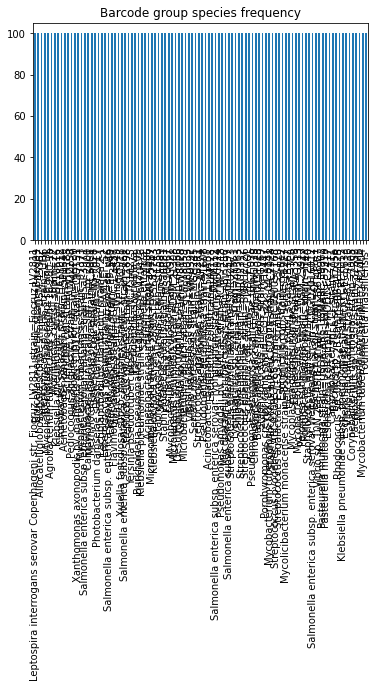

In [105]:
bar_answer_keys_pd['specie'].value_counts().plot(kind = 'bar')
plt.title('Barcode group species frequency')

In [185]:
bar_answer_keys_pd['genera']= bar_answer_keys_pd['specie'].str.split(' ').str[0]


Text(0.5, 1.0, 'Barcode group contaminant frequency')

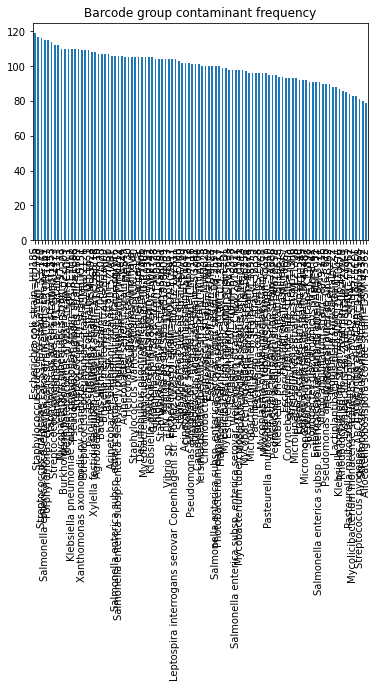

In [106]:
bar_answer_keys_pd['contami'].value_counts().plot(kind = 'bar')
plt.title('Barcode group contaminant frequency')


In [109]:
all_df = bar_answer_keys_pd[['readCount']]

# extract barcodes and read totals
barcodes_all = list(all_df.index)
reads_per_cell = [int(i) for i in list(all_df.sum(axis=1))]

total_reads = sum(reads_per_cell)

reads_per_cell, barcodes_all = (list(t) for t in zip(*sorted(zip(reads_per_cell, barcodes_all), reverse=True)))

print('%d total barcoded reads in experiment' % total_reads)

54608936 total barcoded reads in experiment


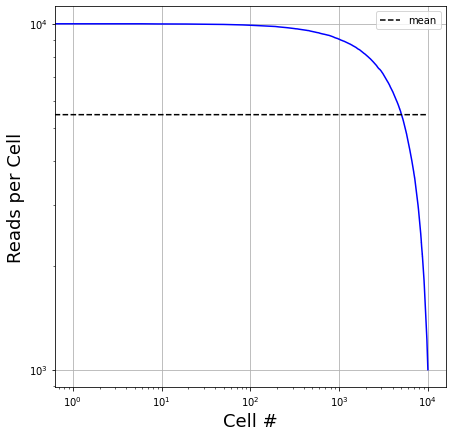

In [110]:
# plot log-log reads per cell vs cells
mean_rpc = np.mean(reads_per_cell)
plt.figure(figsize=(7, 7))
ax = plt.axes()
ax.grid()
plt.loglog(range(len(reads_per_cell)), reads_per_cell, color='b')
plt.loglog(range(len(reads_per_cell)), [mean_rpc] * len(reads_per_cell), color='k', linestyle='--', label='mean')
plt.xlabel('Cell #', fontsize=18)
plt.ylabel('Reads per Cell', fontsize=18)
plt.legend()

Text(0.5, 1.0, 'Barcode group input genera frequency')

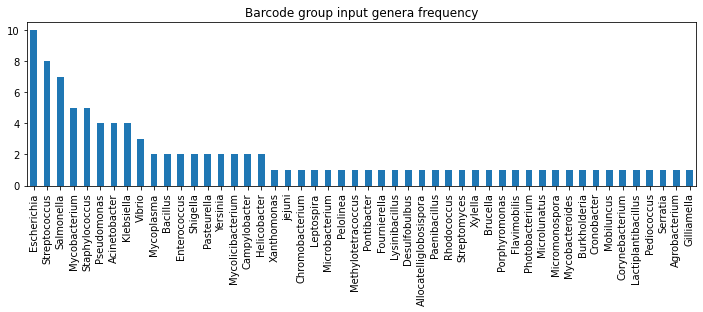

In [113]:
plt.figure(figsize =(12,3
                    ))
refseq_taxa['genera'].value_counts().plot(kind = 'bar')

plt.title('Barcode group input genera frequency')


## Step 3: barcode profiling with Kraken2
use PlusPF database

In [96]:
bar_answer_keys_pd.head()

,specie,specie_read_cnt,contami,contami_reac_cnt
bar,,,,
CTGGGCGCCGTGTAGT,Leptospira interrogans serovar Copenhageni str...,1884,Porphyromonas crevioricanis strain=COT-253 OH1447,831
CATACCTACGTGCCCA,Xanthomonas axonopodis pv. manihotis str. CIO1...,4072,Escherichia coli strain=cattle2,3542
TGTGTGTAGACTCACC,Streptococcus agalactiae FSL S3-170 strain=FSL...,5286,Salmonella enterica subsp. enterica serovar Ty...,2571
GCCAAGCCAACTCTTT,Streptococcus pyogenes ABC020057168 strain=ABC...,1303,Klebsiella pneumoniae subsp. pneumoniae strain...,1102
CGTACCTGGGATCACA,Staphylococcus aureus C2928 strain=C2928,3184,Streptococcus agalactiae strain=SG2R1,1395


In [115]:
# process all the barcode fasta files with kraken2 and bracken
bar_dir ='/drive4/xiangpeng/Project/bacteria/simulation_3/sc_fa/'
ref = '/drive1/xiangpeng/reference/kraken2/plusPF' 
kraken_dir = '/drive4/xiangpeng/Project/bacteria/simulation_3/kraken/'
for bar in bar_answer_keys_pd.index:
    fa1 = bar_dir + 'bar_R1.fa'
    fa2 = bar_dir + 'bar_R2.fa'
    rpt = kraken_dir + 'bar.kraken' # kraken report for each barcode
    outpt = kraken_dir + 'bar.output' # kraken file for each barcode
    # use kracken2 to process all the barcode fasta files 
    kraken_cmd = 'kraken2 --threads 60 --memory-mapping  --db {} --report {} --output {} --paired {} {}'.format(ref, rpt,outpt,fa1,fa2)
    #print(kraken_cmd)
    #os.system(kraken_cmd)
        
    brck = kraken_dir + bar + '_G.bracken'
    # use bracken to process all the kraken report of each the barcodes 
    bracken_cmd = 'bracken -d {} -l G -i {} -o {}'.format(ref, rpt, brck)
    #print(bracken_cmd)
    #os.system(bracken_cmd)

In [168]:
# combine all the bracken output
gns_abd =pd.DataFrame() # initialize the datafram, taxonomyID as index, bar as column, and the values are abundance 
for bar in bar_answer_keys_pd.index:
    brck = kraken_dir + bar + '_G.bracken'
    df = pd.read_csv(brck, sep = '\t')
    
    df = df.set_index('name')
    df = df.rename(columns = {'fraction_total_reads': bar})
    gns_abd = pd.concat([spcs_abd, df[bar]], axis =1)
gns_abd = spcs_abd.fillna(0)

gns_abd = gns_abd.T
gns_ls = gns_abd.columns.tolist()
gns_abd['Detected Purity (Kraken)'] = gns_abd.max(axis =1)
gns_abd['Input Purity'] = bar_answer_keys_pd['specie_read_cnt']/bar_answer_keys_pd['readCount']
gns_abd['readCount'] = bar_answer_keys_pd['readCount']


In [169]:
gns_abd['identified_genera']= gns_abd[gns_ls].idxmax(axis=1)

In [170]:
gns_abd.head()

,Leptospira,Escherichia,Salmonella,Klebsiella,Cronobacter,Yersinia,Serratia,Pseudomonas,Acinetobacter,Vibrio,...,Cedecea,Brevilactibacter,Pimelobacter,Catenulispora,Salinivibrio,Candidatus Blochmannia,Detected Purity (Kraken),Input Purity,readCount,identified_genera
CTGGGCGCCGTGTAGT,0.75339,0.04821,0.03068,0.01873,0.00478,0.00558,0.00558,0.01713,0.01076,0.00677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.75339,0.693923,2715,Leptospira
CATACCTACGTGCCCA,0.00579,0.06845,0.05025,0.02611,0.00536,0.01044,0.00649,0.02668,0.01778,0.01242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.57445,0.534804,7614,Xanthomonas
TGTGTGTAGACTCACC,0.00431,0.04432,0.03112,0.01670,0.00431,0.00970,0.00485,0.02088,0.01239,0.00849,...,0.0,0.0,0.0,0.0,0.0,0.0,0.71673,0.672776,7857,Streptococcus
GCCAAGCCAACTCTTT,0.00596,0.06236,0.05227,0.02751,0.00596,0.01192,0.00779,0.02751,0.02201,0.01100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.61256,0.541788,2405,Streptococcus
CGTACCTGGGATCACA,0.00371,0.04150,0.03362,0.01577,0.00325,0.00580,0.00672,0.01924,0.01252,0.00649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.74380,0.695348,4579,Staphylococcus


<AxesSubplot:xlabel='Input Purity', ylabel='Detected Purity (Kraken)'>

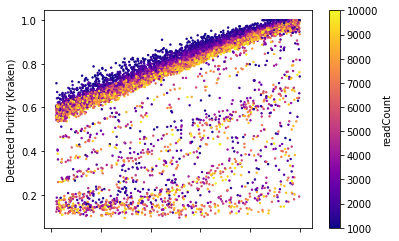

In [143]:
gns_abd

gns_abd.plot.scatter(x = 'Input Purity', 
                    y='Detected Purity (Kraken)', 
                    c = 'readCount',
                    colormap = 'plasma',
                    #figsize=(5,5),
                    s=2,
                    #title = 'Input purity VS predicted purity at species level'
                   )


<AxesSubplot:ylabel='Frequency'>

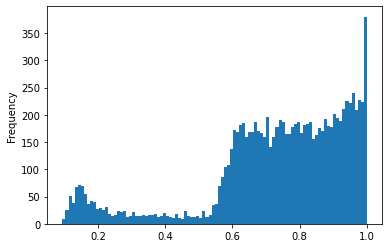

In [142]:
gns_abd['Detected Purity (Kraken)'].plot.hist(bins=100)

,Leptospira,Escherichia,Salmonella,Klebsiella,Cronobacter,Yersinia,Serratia,Pseudomonas,Acinetobacter,Vibrio,...,Echinicola,Cedecea,Brevilactibacter,Pimelobacter,Catenulispora,Salinivibrio,Candidatus Blochmannia,Detected Purity (Kraken),Input Purity,readCount
CTGGGCGCCGTGTAGT,0.75339,0.04821,0.03068,0.01873,0.00478,0.00558,0.00558,0.01713,0.01076,0.00677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75339,0.693923,2715
CATACCTACGTGCCCA,0.00579,0.06845,0.05025,0.02611,0.00536,0.01044,0.00649,0.02668,0.01778,0.01242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.57445,0.534804,7614
TGTGTGTAGACTCACC,0.00431,0.04432,0.03112,0.01670,0.00431,0.00970,0.00485,0.02088,0.01239,0.00849,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.71673,0.672776,7857
GCCAAGCCAACTCTTT,0.00596,0.06236,0.05227,0.02751,0.00596,0.01192,0.00779,0.02751,0.02201,0.01100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.61256,0.541788,2405
CGTACCTGGGATCACA,0.00371,0.04150,0.03362,0.01577,0.00325,0.00580,0.00672,0.01924,0.01252,0.00649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.74380,0.695348,4579


In [146]:
# UMAP visulization of Kraken output

adata_g =  anndata.AnnData(gns_abd[gns_ls], dtype=np.float32)

/tmp/ipykernel_15402/2020720559.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_g =  anndata.AnnData(gns_abd.drop(columns =['Detected Purity (Kraken)', 'Input Purity', 'readCount']))


In [147]:
sc.pp.neighbors(adata_g)#, n_neighbors=100)
sc.tl.leiden(adata_g, resolution=1)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [148]:
sc.tl.umap(adata_g)

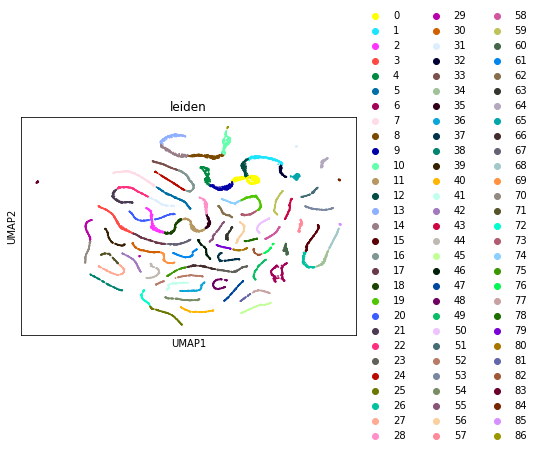

In [149]:
sc.pl.umap(adata_g, color='leiden')

In [186]:
dic_bar_genera = bar_answer_keys_pd['genera'].to_dict()
dic_bar_genera_detect = gns_abd['identified_genera'].to_dict()

adata_g.obs['genera_input'] = (adata_g.obs.index.map(dic_bar_genera).astype('category'))
adata_g.obs['genera_detect'] = (adata_g.obs.index.map(dic_bar_genera_detect).astype('category'))

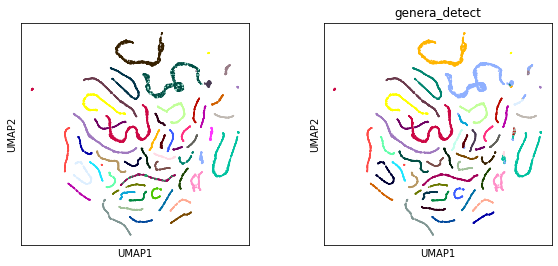

In [372]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (4,4)}):
    sc.pl.umap(adata_g, color=['genera_input', 'genera_detect'], 
               title ='',
               s=10,
               legend_loc=None,
               
              )

In [194]:
kraken_genus = adata_g.obs[['genera_input','genera_detect']]
kraken_genus['match']=kraken_genus.apply(lambda row: 'match' if row['genera_input'] == row['genera_detect'] else 'Not match', axis=1)
kraken_genus['match'].value_counts()

match        9127
Not match     873
Name: match, dtype: int64

In [195]:
dic_bar_match = kraken_genus['match'].to_dict()
adata_g.obs['Match'] = (adata_g.obs.index.map(dic_bar_match).astype('category'))


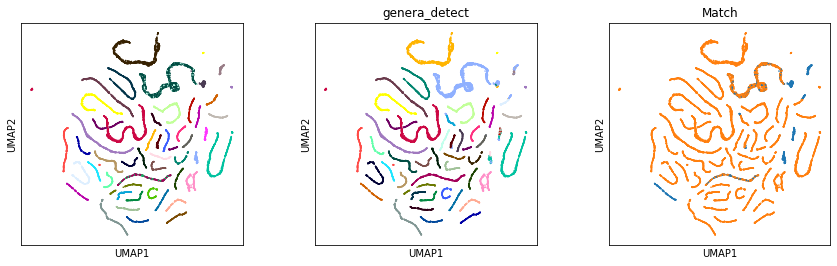

In [378]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (4,4)}):
    sc.pl.umap(adata_g, color=['genera_input', 'genera_detect', 'Match'], 
               title ='',
               s=10,
               legend_loc=None,
               save = 'Kraken_simulation_UMAP.pdf'
              )

In [367]:
adata_g.write(kraken_dir+'Simulation_100_strain_high_contamination_Kraken.h5ad')
gns_abd.to_csv(kraken_dir + 'Simulation_100_strain_high_contamination_kraken.csv')

## Step 4: Kaiju analysis
Kaiju 1.7.4

https://github.com/bioinformatics-centre/kaiju.git

Kaiju Database

wget http://kaiju.binf.ku.dk/database/kaiju_db_nr_euk_2020-05-25.tgz


In [206]:
kaiju_dir = '/drive4/xiangpeng/Project/bacteria/simulation_3/kaiju/'
kj_app = '/drive1/xiangpeng/apps/kaiju/src/kaiju' # The Kaiju application commandlind
kj_dmp = '/drive1/xiangpeng/reference/kaijudb/nodes.dmp' # The Kaiju database nodes dmp
kj_fmi = '/drive1/xiangpeng/reference/kaijudb/kaiju_db_nr_euk.fmi'# the Kaiju database fmi 
kj_name = '/drive1/xiangpeng/reference/kaijudb/names.dmp'# the Kaiju database names
kj_2table = '/drive1/xiangpeng/apps/kaiju/src/kaiju2table'# command to covert kaiju output to a table with taxa name

In [207]:
#process all the fasta files with Kaiju
for bar in bar_answer_keys_pd.index:
    fa1 = bar_dir + 'bar_R1.fa'
    fa2 = bar_dir + 'bar_R2.fa'
    kjoutput = kaiju_dir +bar +'.out'
    kj_cmd = '{} -t {} -f {} -i {} -j {} -o {} -z 4'.format(kj_app,kj_dmp,kj_fmi,fa1,fa2,kjoutput )
    #print(kj_cmd)
    #os.system(kj_cmd)
    
    # combine all the Kaiju output using Kaiju2table toolkit
    kj_tab =  kaiju_dir +bar +'.tsv'
    kj2tb_cmb = '{} -t {} -n {} -r genus -m 0.1 -o {} {}'.format(kj_2table,kj_dmp, kj_name, kj_tab, kjoutput)
    #print(kj2tb_cmb)
    #os.system(kj2tb_cmb)

In [215]:
# combine all the Kaiju tables
kj_tax_abd = pd.DataFrame()
for bar in bar_answer_keys_pd.index:
    kj_tab =  kaiju_dir +bar +'.tsv'
    df =  pd.read_csv(kj_tab, sep = '\t').dropna().set_index('taxon_name')
    df = df.rename(columns = {'percent':bar})
    kj_tax_abd = pd.concat([kj_tax_abd, df[bar]],axis =1)


kj_tax_abd = kj_tax_abd.fillna(0).T
kj_tax_ls = kj_tax_abd.columns.to_list()

In [218]:


kj_tax_abd['Detected Purity (Kaiju)'] = kj_tax_abd[kj_tax_ls].max(axis =1)
kj_tax_abd['Detected taxa'] = kj_tax_abd[kj_tax_ls].idxmax(axis =1)
kj_tax_abd['Input Purity'] = bar_answer_keys_pd['specie_read_cnt']/bar_answer_keys_pd['readCount']
kj_tax_abd['readCount'] = bar_answer_keys_pd['readCount']
kj_tax_abd['readCount']
kj_tax_abd.head()

,Leptospira,Mycobacterium,Salmonella,Vibrio,Escherichia,Pseudomonas,Yersinia,Micromonospora,Klebsiella,Streptococcus,...,Imhoffiella,Rahnella,Edwardsiella,Sutterella,Smaragdicoccus,Sorangium,Detected Purity (Kaiju),Detected taxa,Input Purity,readCount
CTGGGCGCCGTGTAGT,68.066299,1.804788,1.399632,1.104972,0.957643,0.773481,0.478821,0.478821,0.441989,0.441989,...,0.0,0.0,0.0,0.0,0.0,0.0,68.066299,Leptospira,0.693923,2715
CATACCTACGTGCCCA,0.525348,2.456002,2.272130,1.523509,1.221434,1.379039,0.761755,0.879958,0.696086,0.735487,...,0.0,0.0,0.0,0.0,0.0,0.0,46.467033,Xanthomonas,0.534804,7614
TGTGTGTAGACTCACC,0.394553,1.641848,1.540028,0.852743,1.145475,1.132748,0.750923,0.521828,0.432735,19.498535,...,0.0,0.0,0.0,0.0,0.0,0.0,19.498535,Streptococcus,0.672776,7857
GCCAAGCCAACTCTTT,0.540541,2.453223,2.162162,1.164241,1.330561,1.330561,1.039501,0.374220,0.582121,33.430351,...,0.0,0.0,0.0,0.0,0.0,0.0,33.430351,Streptococcus,0.541788,2405
CGTACCTGGGATCACA,0.327582,1.441363,1.375846,0.742520,0.808037,1.157458,0.502293,0.808037,0.524132,0.502293,...,0.0,0.0,0.0,0.0,0.0,0.0,21.533085,Staphylococcus,0.695348,4579


<AxesSubplot:xlabel='Input Purity', ylabel='Detected Purity (Kaiju)'>

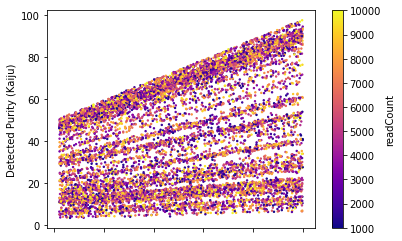

In [221]:
kj_tax_abd.plot.scatter(x = 'Input Purity', 
                    y='Detected Purity (Kaiju)', 
                    c = 'readCount',
                    colormap = 'plasma',
                    #figsize=(5,5),
                    s=2,
                    #title = 'Input purity VS predicted purity at species level'
                   )


<AxesSubplot:ylabel='Frequency'>

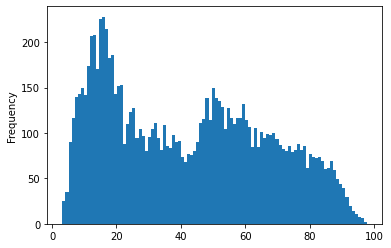

In [222]:
kj_tax_abd['Detected Purity (Kaiju)'].plot.hist(bins=100)

In [228]:
# UMAP visulization of Kraken output

adata_kj =  anndata.AnnData(kj_tax_abd[kj_tax_ls], dtype=np.float32)
adata_kj

AnnData object with n_obs × n_vars = 10000 × 435

In [233]:
sc.pp.neighbors(adata_kj,use_rep='X')#, n_neighbors=100)
sc.tl.leiden(adata_kj, resolution=1)

sc.tl.umap(adata_kj)

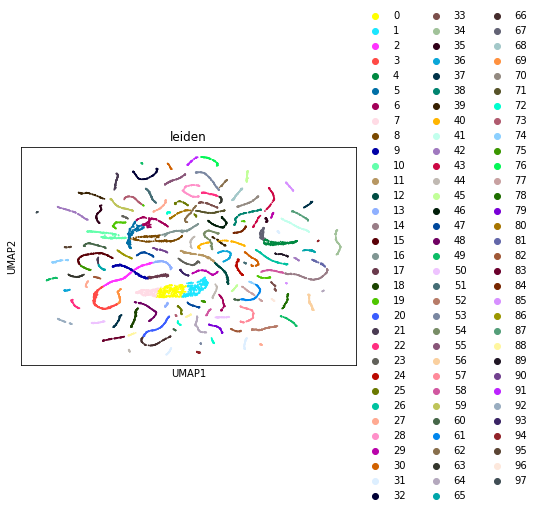

In [237]:
sc.pl.umap(adata_kj, color='leiden')

In [240]:
dic_bar_genera = bar_answer_keys_pd['genera'].to_dict()
dic_kj_bar_genera_detect = kj_tax_abd['Detected taxa'].to_dict()

adata_kj.obs['genera_input'] = (adata_kj.obs.index.map(dic_bar_genera).astype('category'))
adata_kj.obs['genera_detect'] = (adata_kj.obs.index.map(dic_kj_bar_genera_detect).astype('category'))

In [246]:
kj_genus = adata_kj.obs[['genera_input','genera_detect']]
kj_genus['match']=kj_genus.apply(lambda row: 'match' if row['genera_input'] == row['genera_detect'] else 'Not match', axis=1)
kj_genus['match'].value_counts()

match        9319
Not match     681
Name: match, dtype: int64

In [247]:
dic_kj_match = kj_genus['match'].to_dict()

adata_kj.obs['match'] = (adata_kj.obs.index.map(dic_kj_match).astype('category'))

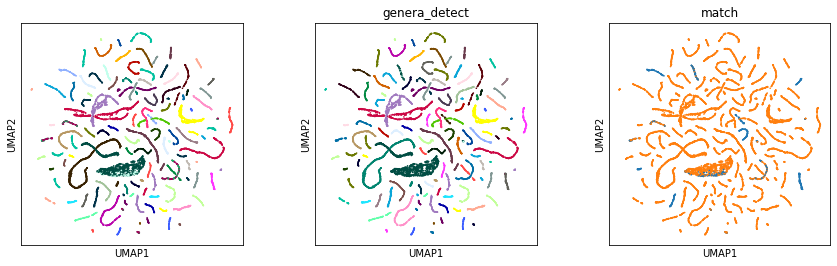

In [377]:
with rc_context({'figure.figsize': (4,4)}):
    sc.pl.umap(adata_kj, color=['genera_input','genera_detect', 'match'], 
               title ='',
               s=10,
               legend_loc=None,
               save = 'Kaiju_simulation_UMAP.pdf'
              )

In [368]:
adata_kj.write(kraken_dir+'Simulation_100_strain_high_contamination_kaiju.h5ad')
kj_tax_abd.to_csv(kraken_dir+'Simulation_100_strain_high_contamination_kaiju.csv')

## Step 5: MetaPhlAn Analysis


https://github.com/biobakery/MetaPhlAn/wiki/MetaPhlAn-3.0

use default database

In [254]:
# process all barcode fa with metaphlan

meta_dir = '/drive4/xiangpeng/Project/bacteria/simulation_3/metaphlan/'
for bar in bar_answer_keys_pd.index:
    fa1 = bar_dir + 'bar_R1.fa'
    fa2 = bar_dir + 'bar_R2.fa'
    meta_bt2 = meta_dir+bar + '.bowtie2out'
    meta_sam = meta_dir+bar + '.sam.bz2'
    meta_out = meta_dir+bar + '_profile.txt'
    meta_cmd = 'metaphlan {} {} --input_type fasta --nproc 60 -s {} --bowti2out {} > {}'.format(fa1, 
                                                                                                fa2,
                                                                                                meta_sam,
                                                                                                meta_bt2,
                                                                                                meta_out
                                                                                               )
    #print(meta_cmd)
    #os.system(meta_cmd)

In [256]:
# merge all profile files into an abundance table
merge_cmd = 'merge_metaphlan_table.py {}*_profile.txt > {}merged_abundace_table.txt'.format(meta_dir, meta_dir)
print(merge_cmd)
#os.system(merge_cmd)

merge_metaphlan_table.py /drive4/xiangpeng/Project/bacteria/simulation_3/metaphlan/*_profile.txt > /drive4/xiangpeng/Project/bacteria/simulation_3/metaphlan/merged_abundace_table.txt


In [257]:
# extract the species abundance table
!grep -E "g__|clade" /drive4/xiangpeng/Project/bacteria/simulation_3/metaphlan/merged_abundace_table.txt | grep -v "s__" | sed 's/^.*g__//g'  | sed -e 's/clade_name/genera/g' > /drive4/xiangpeng/Project/bacteria/simulation_3/metaphlan/merged_abundance_table_genera.txt

In [283]:
meta_output = meta_dir + 'merged_abundance_table_genera.txt'

meta_abd=  pd.read_csv(meta_output, sep ='\t').drop(columns = ['NCBI_tax_id',]).set_index('genera')
meta_abd = meta_abd.T

meta_abd.index = meta_abd.index.str.replace('_profile', '')
meta_abd = meta_abd.loc[:, ~(meta_abd == 'relative_abundance').any()]
meta_genus_ls = meta_abd.columns.to_list()
meta_abd = meta_abd.astype('float32')
meta_abd['Detected Purity (Metaphlan)'] = meta_abd[meta_genus_ls].max(axis =1)
meta_abd['Detected taxa'] = meta_abd[meta_genus_ls].idxmax(axis =1)
meta_abd['Input Purity'] = bar_answer_keys_pd['specie_read_cnt']/bar_answer_keys_pd['readCount']
meta_abd['readCount'] = bar_answer_keys_pd['readCount']




<AxesSubplot:xlabel='Input Purity', ylabel='Detected Purity (Metaphlan)'>

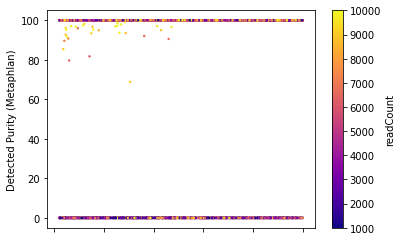

In [285]:
meta_abd.plot.scatter(x = 'Input Purity', 
                    y='Detected Purity (Metaphlan)', 
                    c = 'readCount',
                    colormap = 'plasma',
                    #figsize=(5,5),
                    s=2,
                    #title = 'Input purity VS predicted purity at species level'
                   )


<AxesSubplot:ylabel='Frequency'>

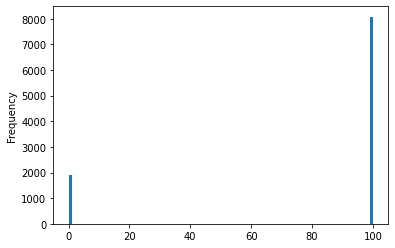

In [287]:
meta_abd['Detected Purity (Metaphlan)'].plot.hist(bins=100)

In [288]:
# UMAP visulization of Kraken output

adata_meta =  anndata.AnnData(meta_abd[meta_genus_ls], dtype=np.float32)
adata_meta

AnnData object with n_obs × n_vars = 10000 × 40

In [289]:
sc.pp.neighbors(adata_meta,use_rep='X')#, n_neighbors=100)
sc.tl.leiden(adata_meta, resolution=1)

sc.tl.umap(adata_meta)

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


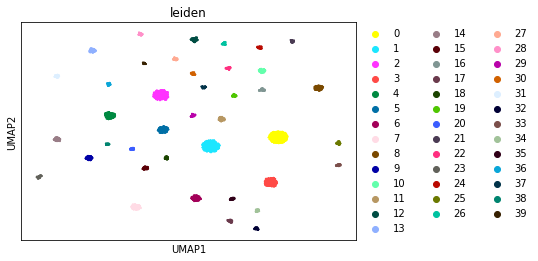

In [290]:
sc.pl.umap(adata_meta, color='leiden')

In [292]:
dic_bar_genera = bar_answer_keys_pd['genera'].to_dict()
dic_meta_bar_genera_detect = meta_abd['Detected taxa'].to_dict()

adata_meta.obs['genera_input'] = (adata_meta.obs.index.map(dic_bar_genera).astype('category'))
adata_meta.obs['genera_detect'] = (adata_meta.obs.index.map(dic_meta_bar_genera_detect).astype('category'))

In [294]:
meta_genus = adata_meta.obs[['genera_input','genera_detect']]
meta_genus['match']=meta_genus.apply(lambda row: 'match' if row['genera_input'] == row['genera_detect'] else 'Not match', axis=1)
meta_genus['match'].value_counts()

match        7623
Not match    2377
Name: match, dtype: int64

In [295]:
dic_meta_match = meta_genus['match'].to_dict()

adata_meta.obs['match'] = (adata_meta.obs.index.map(dic_meta_match).astype('category'))

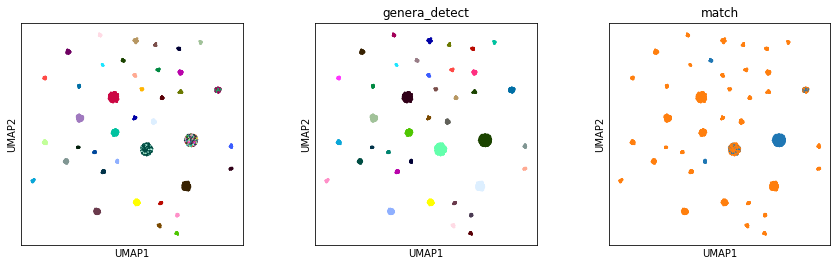

In [376]:
with rc_context({'figure.figsize': (4,4)}):
    sc.pl.umap(adata_meta, color=['genera_input','genera_detect', 'match'], 
               title ='',
               s=10,
               legend_loc=None,
               save = 'MetaPhlAn_simulation_UMAP.pdf'
              )

In [369]:
adata_meta.write(kraken_dir+'Simulation_100_strain_high_contamination_metaphlan.h5ad')
meta_abd.to_csv(kraken_dir+'Simulation_100_strain_high_contamination_metaphlan.csv')

## Step 6: Result evaluation
compare the output of the three taxa profiler

1. correlation between input and output purity
2. Taxa purity after filtering using various threshold
3. Barcode count that pass purity filtering
3. Taxa identification accuracy


#### correlation between input and output purity

In [310]:
# correlation between input and output purity 
# Kraken
kraken_corr = gns_abd['Detected Purity (Kraken)'].corr(gns_abd['Input Purity'])
print('correlation between detected purity and input purity of Kraken is {}'.format(kraken_corr))

#Kaiju
kj_corr = kj_tax_abd['Detected Purity (Kaiju)'].corr(kj_tax_abd['Input Purity'])
print('correlation between detected purity and input purity of Kaiju is {}'.format(kj_corr))

#MetaPhlAn
meta_corr = meta_abd['Detected Purity (Metaphlan)'].corr(meta_abd['Input Purity'])
print('correlation between detected purity and input purity of MetaPhlAn is {}'.format(meta_corr))


correlation between detected purity and input purity of Kraken is 0.597035380285131
correlation between detected purity and input purity of Kaiju is 0.2894734025959643
correlation between detected purity and input purity of MetaPhlAn is 0.04527375603047523


#### Taxa purity after filtering using various threshold

In [331]:
thrshd_dir = '/drive4/xiangpeng/Project/bacteria/simulation_3/analysis/'

In [338]:
thresholds = np.arange(0.50,0.99, 0.001)
# calculate the average purity, standard error, CI,  of the barcodes after data filtering with various purity threshold.
# Kraken
kraken_threshold = pd.DataFrame(columns = ['threshold', 'average_purity', 'standard_err', 'N_pass', 'CI'])
for t in thresholds:
    df = gns_abd[gns_abd['Detected Purity (Kraken)']>=t] # Data filtering by the detected purity
    avg=df['Input Purity'].mean() # average purity after filtering
    stder = df['Input Purity'].std()# standard error of the purity pass filter
    n = len(df['Input Purity']) # number of barcodes that pass filter
    zstar = 1.96 # for 95 percent confidence level zstar = 1.96
    ci = zstar*stder/math.sqrt(n) # critical interval of the purity that pass the filter
    kraken_threshold.loc[len(kraken_threshold)]=[t, avg, stder, n, ci]
kraken_threshold.to_csv(thrshd_dir+ 'kraken_purity_filtering_threshold.csv')
kraken_threshold.head()

,threshold,average_purity,standard_err,N_pass,CI
0,0.500,0.760809,0.141728,8910.0,0.002943
1,0.501,0.760826,0.141722,8908.0,0.002943
2,0.502,0.760848,0.141715,8907.0,0.002943
3,0.503,0.760848,0.141715,8907.0,0.002943
4,0.504,0.760848,0.141715,8907.0,0.002943


In [356]:
thresholds = np.arange(0.50,0.977, 0.001)
# calculate the average purity, standard error, CI,  of the barcodes after data filtering with various purity threshold.
# Kaiju
kj_threshold = pd.DataFrame(columns = ['threshold', 'average_purity', 'standard_err', 'N_pass', 'CI'])
for t in thresholds:
    df = kj_tax_abd[kj_tax_abd['Detected Purity (Kaiju)']>=(t*100)] # Data filtering by the detected purity
    avg=df['Input Purity'].mean() # average purity after filtering
    stder = df['Input Purity'].std()# standard error of the purity pass filter
    n = len(df['Input Purity']) # number of barcodes that pass filter
    zstar = 1.96 # for 95 percent confidence level zstar = 1.96
    ci = zstar*stder/math.sqrt(n) # critical interval of the purity that pass the filter
    kj_threshold.loc[len(kj_threshold)]=[t, avg, stder, n, ci]
kj_threshold.to_csv(thrshd_dir+ 'kaiju_purity_filtering_threshold.csv')
kj_threshold.head()

,threshold,average_purity,standard_err,N_pass,CI
0,0.500,0.787073,0.131056,4023.0,0.004050
1,0.501,0.787463,0.130576,4000.0,0.004047
2,0.502,0.788143,0.130106,3980.0,0.004042
3,0.503,0.788268,0.130056,3972.0,0.004045
4,0.504,0.788934,0.129656,3958.0,0.004039


In [340]:
thresholds = np.arange(0.50,0.99, 0.001)
# calculate the average purity, standard error, CI,  of the barcodes after data filtering with various purity threshold.
# Metaphlan
meta_threshold = pd.DataFrame(columns = ['threshold', 'average_purity', 'standard_err', 'N_pass', 'CI'])
for t in thresholds:
    df = meta_abd[meta_abd['Detected Purity (Metaphlan)']>=t] # Data filtering by the detected purity
    avg=df['Input Purity'].mean() # average purity after filtering
    stder = df['Input Purity'].std()# standard error of the purity pass filter
    n = len(df['Input Purity']) # number of barcodes that pass filter
    zstar = 1.96 # for 95 percent confidence level zstar = 1.96
    ci = zstar*stder/math.sqrt(n) # critical interval of the purity that pass the filter
    meta_threshold.loc[len(meta_threshold)]=[t, avg, stder, n, ci]
meta_threshold.to_csv(thrshd_dir+ 'metaphlan_purity_filtering_threshold.csv')
meta_threshold.head()

,threshold,average_purity,standard_err,N_pass,CI
0,0.500,0.757804,0.141285,8110.0,0.003075
1,0.501,0.757804,0.141285,8110.0,0.003075
2,0.502,0.757804,0.141285,8110.0,0.003075
3,0.503,0.757804,0.141285,8110.0,0.003075
4,0.504,0.757804,0.141285,8110.0,0.003075


In [343]:
thresholds = np.arange(0.50,0.99, 0.001)
# calculate the average purity, standard error, CI,  of the barcodes after data filtering with various purity threshold.
# input
input_threshold = pd.DataFrame(columns = ['threshold', 'average_purity', 'standard_err', 'N_pass', 'CI'])
for t in thresholds:
    df = meta_abd[meta_abd['Input Purity']>=t] # Data filtering by the detected purity
    avg=df['Input Purity'].mean() # average purity after filtering
    stder = df['Input Purity'].std()# standard error of the purity pass filter
    n = len(df['Input Purity']) # number of barcodes that pass filter
    zstar = 1.96 # for 95 percent confidence level zstar = 1.96
    ci = zstar*stder/math.sqrt(n) # critical interval of the purity that pass the filter
    input_threshold.loc[len(input_threshold)]=[t, avg, stder, n, ci]
input_threshold.to_csv(thrshd_dir+ 'Input_purity_filtering_threshold.csv')
input_threshold.head()

,threshold,average_purity,standard_err,N_pass,CI
0,0.500,0.754748,0.141826,10000.0,0.00278
1,0.501,0.754748,0.141826,10000.0,0.00278
2,0.502,0.754748,0.141826,10000.0,0.00278
3,0.503,0.754748,0.141826,10000.0,0.00278
4,0.504,0.754748,0.141826,10000.0,0.00278


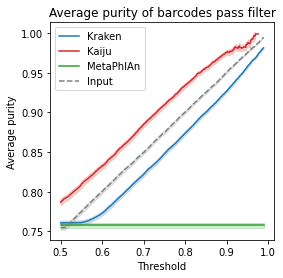

In [362]:
plt.figure(figsize =(4,4))

# add kraken data
plt.plot(kraken_threshold['threshold'],kraken_threshold['average_purity'],c = 'tab:blue',label ='Kraken')
plt.fill_between(kraken_threshold['threshold'],(kraken_threshold['average_purity']-kraken_threshold['CI']),(kraken_threshold['average_purity']+kraken_threshold['CI']),color = 'tab:blue',alpha=0.2)

# add kaiju data
plt.plot(kj_threshold['threshold'],kj_threshold['average_purity'],c = 'tab:red',label ='Kaiju')
plt.fill_between(kj_threshold['threshold'],(kj_threshold['average_purity']-kj_threshold['CI']),(kj_threshold['average_purity']+kj_threshold['CI']),color = 'tab:red',alpha=0.2)

# add metaphlan data
plt.plot(meta_threshold['threshold'],meta_threshold['average_purity'],c = 'tab:green',label ='MetaPhlAn')
plt.fill_between(meta_threshold['threshold'],(meta_threshold['average_purity']-meta_threshold['CI']),(meta_threshold['average_purity']+meta_threshold['CI']),color = 'tab:green',alpha=0.2)

# add input data
plt.plot(input_threshold['threshold'],input_threshold['average_purity'],'--',c = 'tab:gray',label ='Input')
plt.fill_between(input_threshold['threshold'],(input_threshold['average_purity']-input_threshold['CI']),(input_threshold['average_purity']+input_threshold['CI']),color = 'tab:gray',alpha=0.2)


plt.title('Average purity of barcodes pass filter')
plt.xlabel('Threshold')
plt.ylabel('Average purity')

#plt.ylim((0.7,1))
plt.legend()
plt.savefig(thrshd_dir + 'Average_purity_VS_threshold_2.pdf',bbox_inches='tight')
plt.show()

#### Barcode count that pass purity filtering

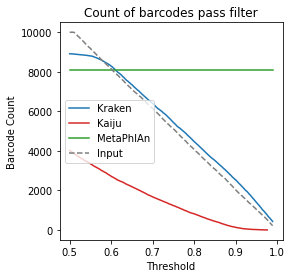

In [366]:
plt.figure(figsize =(4,4))

# add kraken data
plt.plot(kraken_threshold['threshold'],kraken_threshold['N_pass'],c = 'tab:blue',label ='Kraken')

# add kaiju data
plt.plot(kj_threshold['threshold'],kj_threshold['N_pass'],c = 'tab:red',label ='Kaiju')

# add MetaPhlAn data
plt.plot(meta_threshold['threshold'],meta_threshold['N_pass'],c = 'tab:green',label ='MetaPhlAn')

# add Input data
plt.plot(input_threshold['threshold'],input_threshold['N_pass'],'--', c = 'tab:gray',label ='Input')

plt.title('Count of barcodes pass filter')
plt.ylabel('Barcode Count')
plt.xlabel('Threshold')

plt.legend()
plt.savefig(thrshd_dir + 'barcode_count_VS_threshold_2.pdf',bbox_inches='tight')

plt.show()

#### Taxa identification accuracy

Text(0.5, 1.0, 'Taxon identification accuracy')

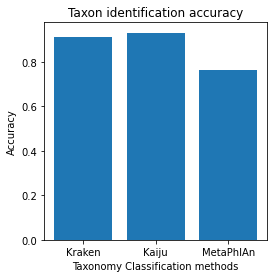

In [318]:
kraken_match = kraken_genus['match'].value_counts().tolist()
Kj_match = kj_genus['match'].value_counts().tolist()
meta_match =  meta_genus['match'].value_counts().tolist()

methods = ['Kraken', 'Kaiju', 'MetaPhlAn']
accuracy = [kraken_match[0]/sum(kraken_match),
            Kj_match[0]/sum(Kj_match),
            meta_match[0]/sum(meta_match)
           ]

fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(methods, accuracy)
ax.set_xlabel('Taxonomy Classification methods')
ax.set_ylabel('Accuracy')
ax.set_title('Taxon identification accuracy')
